<a href="https://colab.research.google.com/github/PietroDF/Standard_Machine_Learning/blob/master/Outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isolation Forest

 Inspiring tutorial @ https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623

 Winsconsin Breast Cancer Dataset @ https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/

 Dataset Explanation @ https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names

 Complete dataset collection @ https://archive.ics.uci.edu/ml/datasets.php 

# Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
rng = np.random.RandomState(42)

# Dataset

## Data gathering

In [0]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

In [0]:
dataset = pd.read_csv(dataset_url, header=None)

## Data preparation

In [0]:
renaming_dict = {0: 'user_id', 1: 'label'}

for i in range(2,32):
  renaming_dict[i] = 'feature_'+str(100+i-1)[1:]

In [0]:
dataset = dataset.rename(columns=renaming_dict)

In [0]:
dataset.head()

,user_id,label,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
dataset = dataset.drop(['user_id'], axis=1)

In [0]:
dataset.head()

,label,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Data sampling

In [0]:
label_count = dataset[['label','feature_02']].groupby(['label']).count().rename(columns={'feature_02':'count'})

In [0]:
label_count

,count
label,
B,357
M,212


In [0]:
num_benignant = label_count.loc['B'].values[0]
num_malignant = label_count.loc['M'].values[0]

In [0]:
num_benignant, num_malignant

(357, 212)

In [0]:
# Downsample the M class to be an outlier
downsampling_value = 0.05*num_benignant/num_malignant
downsampling_value

0.08419811320754718

In [0]:
downsampled_M_df = dataset[dataset['label']=='M'].sample(frac=downsampling_value, replace=False, random_state=1)

In [0]:
downsampled_M_df.shape

(18, 31)

In [0]:
notsampled_B_df = dataset[dataset['label']=='B']

In [0]:
notsampled_B_df.shape

(357, 31)

In [0]:
# Operations: union/shuffle/reset_indexes/remove_created_column
sampled_df = pd.concat([notsampled_B_df, downsampled_M_df]).sample(frac=1).reset_index().drop(['index'], axis=1)

In [0]:
sampled_df

,label,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,B,13.170,18.22,84.28,537.3,0.07466,0.05994,0.04859,0.02870,0.1454,0.05549,0.2023,0.6850,1.236,16.89,0.005969,0.014930,0.01564,0.008463,0.01093,0.001672,14.900,23.89,95.10,687.6,0.12820,0.19650,0.18760,0.10450,0.2235,0.06925
1,B,11.280,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,0.06072,0.3384,1.3430,1.851,26.33,0.011270,0.034980,0.02187,0.019650,0.01580,0.003442,11.920,15.77,76.53,434.0,0.13670,0.18220,0.08669,0.08611,0.2102,0.06784
2,B,11.150,13.08,70.87,381.9,0.09754,0.05113,0.01982,0.01786,0.1830,0.06105,0.2251,0.7815,1.429,15.48,0.009019,0.008985,0.01196,0.008232,0.02388,0.001619,11.990,16.30,76.25,440.8,0.13410,0.08971,0.07116,0.05506,0.2859,0.06772
3,B,12.950,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,0.06470,0.2094,0.7636,1.231,17.67,0.008725,0.020030,0.02335,0.011320,0.02625,0.004726,13.740,19.93,88.81,585.4,0.14830,0.20680,0.22410,0.10560,0.3380,0.09584
4,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905,0.2773,0.9768,1.909,15.70,0.009606,0.014320,0.01985,0.014210,0.02027,0.002968,10.230,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,M,16.270,20.71,106.90,813.7,0.11690,0.13190,0.14780,0.08488,0.1948,0.06277,0.4375,1.2320,3.270,44.41,0.006697,0.020830,0.03248,0.013920,0.01536,0.002789,19.280,30.38,129.80,1121.0,0.15900,0.29470,0.35970,0.15830,0.3103,0.08200
371,B,10.510,23.09,66.85,334.2,0.10150,0.06797,0.02495,0.01875,0.1695,0.06556,0.2868,1.1430,2.289,20.56,0.010170,0.014430,0.01861,0.012500,0.03464,0.001971,10.930,24.22,70.10,362.7,0.11430,0.08614,0.04158,0.03125,0.2227,0.06777
372,B,9.755,28.20,61.68,290.9,0.07984,0.04626,0.01541,0.01043,0.1621,0.05952,0.1781,1.6870,1.243,11.28,0.006588,0.012700,0.01450,0.006104,0.01574,0.002268,10.670,36.92,68.03,349.9,0.11100,0.11090,0.07190,0.04866,0.2321,0.07211
373,B,12.360,21.80,79.78,466.1,0.08772,0.09445,0.06015,0.03745,0.1930,0.06404,0.2978,1.5020,2.203,20.95,0.007112,0.024930,0.02703,0.012930,0.01958,0.004463,13.830,30.50,91.46,574.7,0.13040,0.24630,0.24340,0.12050,0.2972,0.09261


In [0]:
feature_list = list(sampled_df.drop(['label'], axis=1).columns)

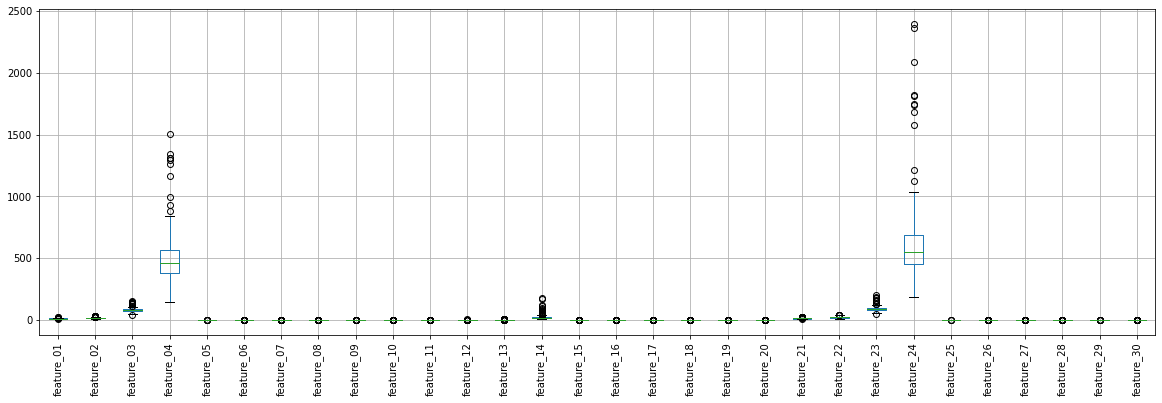

In [0]:
boxplot = sampled_df.boxplot(column=feature_list, figsize=(20,6), rot=90)

### Scaling variables

In [0]:
scaler = StandardScaler()

In [0]:
sampled_df[feature_list] = scaler.fit_transform(sampled_df[feature_list])

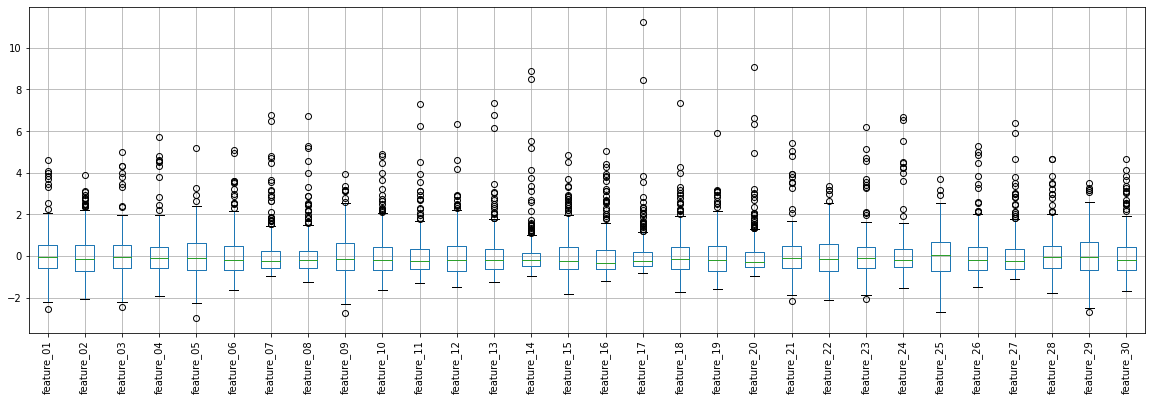

In [0]:
boxplot = sampled_df.boxplot(column=feature_list, figsize=(20,6), rot=90)

In [0]:
sampled_df.head()

,label,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,B,0.091628,0.072171,0.003087,0.019346,-0.675780,-1.063399,-0.921616,-1.140924,-0.219384,-0.649317,-0.186905,0.227118,-0.372753,-0.063141,-0.258761,-0.840720,-0.769819,-1.245132,0.759170,-0.570012,-0.090807,-0.132444,-0.217746,-0.131442,-1.098648,-1.135487,-1.072264,-1.589331,-0.506849,-1.085663
1,B,0.082261,0.237542,0.146590,0.001525,-0.404969,0.513954,0.911223,0.660641,-0.869074,-0.158721,0.413603,0.447699,1.013241,0.230013,0.892470,1.206102,1.087722,1.645011,0.857572,0.188854,-0.139167,-0.247819,-0.035286,-0.193311,-0.812142,0.053243,0.324433,0.274717,-1.397066,-0.569947
2,B,0.606768,-0.438752,0.547573,0.501057,-0.023473,-0.285726,-0.637828,-0.443085,-0.480845,-0.201965,-0.643918,-1.271967,-0.696245,-0.365602,-1.106426,-0.887209,-0.610531,-0.873330,-1.436063,-0.680204,0.783397,-0.643646,0.628111,0.643953,0.017738,-0.335428,-0.383435,0.150044,0.190952,-0.165276
3,M,3.997331,1.723416,4.340436,4.797477,1.240556,3.579607,4.796537,5.209608,1.571226,0.877646,4.507672,-0.331226,6.168657,5.541105,-0.253453,1.250803,1.568209,2.781312,0.015367,0.884654,3.923091,0.991136,4.715014,4.517592,0.724125,1.991273,2.846287,3.864895,0.476099,1.259245
4,B,0.686381,-0.221548,0.594263,0.574567,-0.386522,-0.572076,-0.697993,-0.767917,-0.548191,-0.597126,-0.550067,-0.624012,-0.582837,-0.327212,-0.850633,-0.771523,-0.547982,-0.918747,-1.156775,-0.676392,0.649476,-0.043694,0.559557,0.467979,-0.510816,-0.525327,-0.619690,-0.649996,-0.833725,-0.574034


In [0]:
true_labels = list(sampled_df['label'].values)

# Models and Evaluation

In [0]:
from sklearn.cluster import DBSCAN

In [0]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [0]:
def calculate_metrics(true_labels,predicted_labels):

  f1 = f1_score(true_labels, predicted_labels, pos_label='M')
  precision = precision_score(true_labels, predicted_labels, pos_label='M')
  recall = recall_score(true_labels, predicted_labels, pos_label='M')
  cm = confusion_matrix(true_labels, predicted_labels, labels=['B','M'])

  msg = f'precision:\t {precision}\nrecall:\t\t {recall}\nf1-score:\t {f1}'
  print(msg)
  return cm


# # To plot the confusion matrix
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# plt.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + my_labels)
# ax.set_yticklabels([''] + my_labels)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

## DB-Scan

### Modeling

In [0]:
outlier_detection = DBSCAN(min_samples = 2, eps = 5.5)

In [0]:
predicted_labels = outlier_detection.fit_predict(sampled_df[feature_list])

In [0]:
list(predicted_labels).count(-1)

365

In [0]:
predicted_labels = [(lambda x: 'M' if x<0 else 'B')(x) for x in predicted_labels]

In [0]:
predicted_labels[:10]

['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M']

### Evaluation

In [0]:
calculate_metrics(true_labels,predicted_labels)

precision:	 0.4
recall:		 0.4444444444444444
f1-score:	 0.4210526315789474


In [0]:
calculate_metrics(true_labels,predicted_labels)

precision:	 0.049315068493150684
recall:		 1.0
f1-score:	 0.09399477806788512


array([[ 10, 347],
       [  0,  18]])

## Isolation Forest

In [0]:
from sklearn.ensemble import IsolationForest

### Modeling

In [0]:
isfor_clf = IsolationForest(max_samples=100, random_state=rng)

In [0]:
isfor_clf.fit(sampled_df[feature_list])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F7159D05A98, verbose=0,
                warm_start=False)

In [0]:
# For each observation, tells whether or not (+1 or -1) it should be considered as an inlier according to the fitted model
predicted_labels = isfor_clf.predict(sampled_df[feature_list])

In [0]:
predicted_labels = [(lambda x: 'M' if x<0 else 'B')(x) for x in predicted_labels]

In [0]:
predicted_labels[:10]

['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M']

### Evaluation

In [0]:
calculate_metrics(true_labels,predicted_labels) # with variables scaling

precision:	 0.2727272727272727
recall:		 0.6666666666666666
f1-score:	 0.3870967741935484


In [0]:
calculate_metrics(true_labels,predicted_labels) # without variables scaling

precision:	 0.022222222222222223
recall:		 0.05555555555555555
f1-score:	 0.031746031746031744


array([[313,  44],
       [ 17,   1]])